In [1]:
import time
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
#from sklearn import pipeline, model_selection
from sklearn import pipeline, grid_search
#from sklearn.feature_extraction import DictVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import TruncatedSVD
#from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, make_scorer
#from nltk.metrics import edit_distance
from nltk.stem.porter import *
stemmer = PorterStemmer()
#from nltk.stem.snowball import SnowballStemmer #0.003 improvement but takes twice as long as PorterStemmer
#stemmer = SnowballStemmer('english')
import re
#import enchant
import random
random.seed(2016)
from autocorrect import spell
import enchant
import nltk
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
df_train = pd.read_csv('C:/Users/sneha/Google Drive/Github/DataSet/Kaggle/data/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('C:/Users/sneha/Google Drive/Github/DataSet/Kaggle/data/test.csv', encoding="ISO-8859-1") 
df_prod = pd.read_csv('C:/Users/sneha/Google Drive/Github/DataSet/Kaggle/data/product_descriptions.csv') #update here

## Analysing Part of speech in the search terms

In [3]:
def pos_tagging(str1):
    return [nltk.pos_tag([w]) for w in str1.split()]
        

In [4]:
df_train['search_term'].head(10).apply(pos_tagging)

0                    [[(angle, NN)], [(bracket, NN)]]
1                        [[(l, NN)], [(bracket, NN)]]
2                        [[(deck, NN)], [(over, IN)]]
3       [[(rain, NN)], [(shower, JJR)], [(head, NN)]]
4     [[(shower, JJR)], [(only, RB)], [(faucet, NN)]]
5                   [[(convection, NN)], [(otr, NN)]]
6    [[(microwave, NN)], [(over, IN)], [(stove, IN)]]
7                               [[(microwaves, NNS)]]
8                  [[(emergency, NN)], [(light, NN)]]
9                          [[(mdf, NN)], [(3/4, CD)]]
Name: search_term, dtype: object

[('Noun', 582798), ('numeral', 68361), ('adjective ', 51989), ('preposition', 48374), ('Verb', 46716), ('List', 13916), ('Pronoun', 10582), ('adjective', 10448), ('adverb', 9758), ('conjunction', 6284), ('determiner', 3911), ('TO', 1783), (':', 740), ('MD', 576), ('-NONE-', 564), ('POS', 171), ('WP', 143), ('WRB', 32), (',', 29), ('$', 24), ('.', 12)]


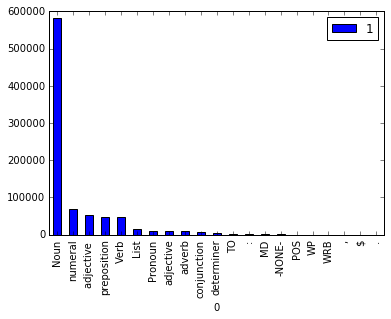

In [5]:
import operator
pos_dict = dict()

dict_chunk = {'NN':'Noun', 'NNP':'Noun', 'NNPS':'Noun','NNS':'Noun', 'CD': 'numeral', 'JJ':'adjective ','IN':'preposition',
              'VBG':'Verb','VBD':'Verb','LS':'List','JJR':'adjective', 'JJS':'adjective', 'RB':'adverb','RBR':'adverb',
              'RBS':'adverb', 'PRP$':'Pronoun', 'CC': 'conjunction','PRP':'Pronoun','DT': 'determiner',              
              'VB':'Verb','VBN':'Verb','VBP':'Verb','VBZ':'Verb'              
              }


for a in df_train['search_term'].apply(pos_tagging):
    for b in a :
        for b in a :
            temp = ''
            if b[0][1] in dict_chunk:
                temp = dict_chunk[b[0][1]]
            else:
                temp = b[0][1]
        
            if temp in pos_dict:
                pos_dict[temp] = pos_dict[temp] + 1
            else:
                pos_dict[temp] = 1



sorted_train = sorted(pos_dict.items(), key=operator.itemgetter(1),reverse=True)
print (sorted_train)

df = pd.DataFrame(sorted_train)
df.set_index(0).plot(kind='bar')  

[('Noun', 1190730), ('numeral', 148631), ('adjective ', 98874), ('Verb', 95175), ('preposition', 93233), ('List', 32270), ('adjective', 23166), ('Pronoun', 21582), ('adverb', 19165), ('conjunction', 12562), ('determiner', 4982), ('TO', 2289), (':', 1613), ('-NONE-', 917), ('MD', 821), ('POS', 300), ('WP', 257), ('WRB', 201), ('.', 131), (',', 78)]


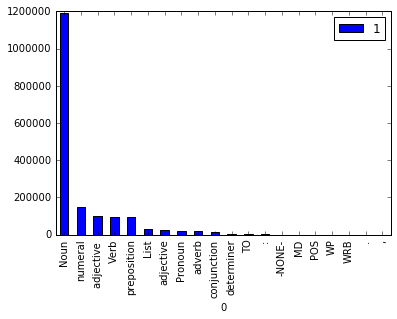

In [6]:
import operator
pos_dict = dict()

dict_chunk = {'NN':'Noun', 'NNP':'Noun', 'NNPS':'Noun','NNS':'Noun', 'CD': 'numeral', 'JJ':'adjective ','IN':'preposition',
              'VBG':'Verb','VBD':'Verb','LS':'List','JJR':'adjective', 'JJS':'adjective', 'RB':'adverb','RBR':'adverb',
              'RBS':'adverb', 'PRP$':'Pronoun', 'CC': 'conjunction','PRP':'Pronoun','DT': 'determiner',              
              'VB':'Verb','VBN':'Verb','VBP':'Verb','VBZ':'Verb'              
              }


for a in df_test['search_term'].apply(pos_tagging):
    for b in a :
        for b in a :
            temp = ''
            if b[0][1] in dict_chunk:
                temp = dict_chunk[b[0][1]]
            else:
                temp = b[0][1]
        
            if temp in pos_dict:
                pos_dict[temp] = pos_dict[temp] + 1
            else:
                pos_dict[temp] = 1



sorted_test = sorted(pos_dict.items(), key=operator.itemgetter(1),reverse=True)
print (sorted_test)

df = pd.DataFrame(sorted_test)
df.set_index(0).plot(kind='bar')  

[('Noun', 108003955), ('preposition', 23575074), ('Verb', 19806973), ('adjective ', 19382200), ('determiner', 16982454), ('conjunction', 11207221), ('numeral', 7088846), ('adverb', 5895006), ('TO', 5766153), ('Pronoun', 5596620), ('adjective', 1966533), ('MD', 1624072), ('List', 1268461), ('WRB', 539855), (':', 424604), ('-NONE-', 330899), ('WDT', 193841), ('WP', 68081), ('EX', 63595), ('#', 21878), ('PDT', 19564), (',', 14265), ('.', 1579), ('$', 105)]


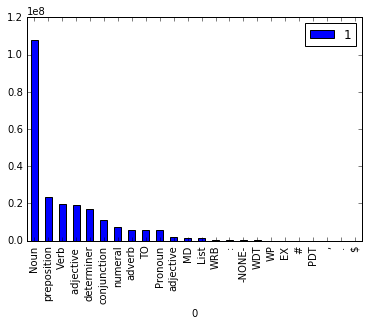

In [9]:
import operator
pos_dict = dict()

dict_chunk = {'NN':'Noun', 'NNP':'Noun', 'NNPS':'Noun','NNS':'Noun', 'CD': 'numeral', 'JJ':'adjective ','IN':'preposition',
              'VBG':'Verb','VBD':'Verb','LS':'List','JJR':'adjective', 'JJS':'adjective', 'RB':'adverb','RBR':'adverb',
              'RBS':'adverb', 'PRP$':'Pronoun', 'CC': 'conjunction','PRP':'Pronoun','DT': 'determiner',              
              'VB':'Verb','VBN':'Verb','VBP':'Verb','VBZ':'Verb'              
              }


for a in df_prod['product_description'].head(10000).apply(pos_tagging):
    for b in a :
        for b in a :
            temp = ''
            if b[0][1] in dict_chunk:
                temp = dict_chunk[b[0][1]]
            else:
                temp = b[0][1]
        
            if temp in pos_dict:
                pos_dict[temp] = pos_dict[temp] + 1
            else:
                pos_dict[temp] = 1



sorted_test = sorted(pos_dict.items(), key=operator.itemgetter(1),reverse=True)
print (sorted_test)

df = pd.DataFrame(sorted_test)
df.set_index(0).plot(kind='bar')  

### Length of the Search terms

In [ ]:
def length(str1):
    return len(str1.split())

In [ ]:
df_test['len_search_term'] = df_test['search_term'].apply(length)
df_train['len_search_term'] = df_train['search_term'].apply(length)

In [ ]:
from collections import Counter
Counter(df_train['len_search_term'])

In [ ]:
from collections import Counter
Counter(df_test['len_search_term'])

In [ ]:
dict_chunk = {'NN':'Noun', 'NNP':'Noun', 'NNPS':'Noun', 'CD': 'numeral', 'JJ':'adjective ','IN':'preposition',
              'VBG':'Verb','VBD':'Verb','LS':'List','JJR':'adjective', 'JJS':'adjective', 'RB':'adverb','RBR':'adverb',
              'RBS':'adverb', 'PRP$':'Pronoun', 'CC': 'conjunction','PRP':'Pronoun','DT': 'determiner',              
              'VB':'Verb','VBN':'Verb','VBP':'Verb','VBZ':'Verb'              
              }

In [ ]:
df_prod.head()